In [17]:
import pandas as pd
import numpy as np
#import pdb
import matplotlib.pyplot as plt
%matplotlib inline


# Observaciones


+ Los indicadores se utilizarán para generar la métrica de consenso y a partir de esta generar las señales.
+ ¿Cómo cruzar individuos? (Se facilita si cada individuo tiene el mismo número de indicadores)
+ ¿Mutuar sólo parámetros del indicador o el indicador en su totalidad?
+ ¿Cómo calcular el fitness?

In [2]:

#Prepares the data

data=pd.read_csv('amxl.csv')

#The next line was neccesary for handling Date column, some hidden characters appeared when reading the csv file
data.columns = ['Date','Open','High','Low','Close','Volume'] 

#Converts string dates to dates
data['Date'] = pd.to_datetime(data['Date'])

#Sorts the data from oldest to newest
data=data.sort_values(by='Date')

In [13]:
#Defines the domain for the parameters
#The format is:
#[lowerBound,upperBound] For numerical parameters
#[category1,...,categoryN] For categorical parameters
sigma=[0.1,3]
timeWindow=[5,30]
typeMA=['simple','exponential']
indicatorKinds=['BB','MA']
indicatorsNumber=[10,10]


def selectNumericalReal(limits):
    '''
    Selects a real random number between the limits
    '''
    return np.random.uniform(limits[0],limits[1],1)[0]

def selectNumericalInteger(limits):
    '''
    Selects a random integer between the limits
    '''
    return np.random.choice(range(limits[0],limits[1]+1),1)[0]

def selectCategorical(kinds):
    '''
    Selects a random category
    '''
    return np.random.choice(kinds,1)[0]

def getMaxTimeWindow(indicators):
    '''
    Returns the max value for the time window in all the indicators from one individual
    '''
    maxTimeWindow=[]
    for indicator in indicators:
        maxTimeWindow.append(indicator.params['timeWindow'])
    return  np.max(maxTimeWindow)

def movingAverage(data,method='simple'):
    if method=='simple':
        return np.mean(data)

                
class indicator:
    '''
    Creates a randomly chosen technical indicator
    '''
        
    def __init__(self):
        self.params = {}
        self.params['indicator'] = selectCategorical(indicatorKinds) 
        
        if self.params['indicator']=='BB':
            self.params['timeWindow'] = selectNumericalInteger(timeWindow)
            self.params['stdDev'] = selectNumericalReal(sigma)
            self.params['movingAverageMethod'] = selectCategorical(typeMA)
            #if exponentialMA:
            #Smoothing parameter
            #self.params['priceType'] (close,low,high,open)
            
        elif self.params['indicator']=='MA':
            self.params['timeWindow'] = selectNumericalInteger(timeWindow)
            self.params['movingAverageMethod'] = selectCategorical(typeMA)
            
    def bollingerSignals(self,data,start):
        '''
        Returns signals generated by a Bollinger Band indicator
        '''
        signal=[0]
        lowerBound=[]
        upperBound=[]
        for t in range(0,len(data) - start + 1):
            lowerBound.append(movingAverage(data['Close'][t:t + start + 1]) - self.params['stdDev']*np.std(data['Close'][t:t + start + 1]))
            upperBound.append(movingAverage(data['Close'][t:t + start + 1]) + self.params['stdDev']*np.std(data['Close'][t:t + start + 1]))
            
        auxRow=0    
        for t in range(start + 1,len(data)):
            
            if data['Close'][t] > upperBound[auxRow+1] and data['Close'][t-1] > upperBound[auxRow]:
                signal.append(1)
            elif data['Close'][t] > lowerBound[auxRow+1] and data['Close'][t-1] < lowerBound[auxRow]:
                signal.append(1)
            elif data['Close'][t] < lowerBound[auxRow+1] and data['Close'][t-1] < lowerBound[auxRow]:
                signal.append(-1)
            elif data['Close'][t] < upperBound[auxRow+1] and data['Close'][t-1] < upperBound[auxRow]:
                signal.append(-1)
            else:
                signal.append(0)
            auxRow=auxRow + 1 
        return signal    

class individual:
    '''
    creates an individual from the population
    '''
    def __init__(self):
        self.numberIndicators = selectNumericalInteger(indicatorsNumber)
        self.indicators=[]
        for i in range(0,self.numberIndicators):
            self.indicators.append(indicator())    
        self.maxTimeWindow=getMaxTimeWindow(self.indicators)
        self.signals = pd.DataFrame(columns=range(0,self.numberIndicators +1))
        self.signals[0]=data['Date'][self.maxTimeWindow:] #First column contains the dates
    
    def getSignals(self,data):
        '''
        Gets the trading signals for a specific indicator using the data in the dataset
        ======
        Params:
        data: A pandas data set containing the data
        ======

        ======
        Output:
        signals: Pandas dataframe with dates and signals
        ======
        '''
        for i in range(1,self.numberIndicators+1):
            indicator = self.indicators[i-1]
            if indicator.params['indicator']=='BB':
                self.signals[i] = indicator.bollingerSignals(data=data,start=self.maxTimeWindow)
            

In [28]:
#Creates population
populationSize=50
population=[]

for i in range(0,populationSize):
    population.append(individual())

In [29]:
#Gets population signals
for i in range(0,len(population)):
    population[i].getSignals(data=data)

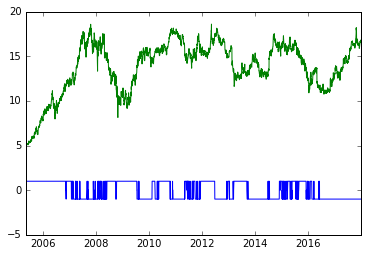

In [46]:
plt.plot(population[2].signals[0],population[2].signals[4],'-')

plt.plot(data['Date'][population[2].maxTimeWindow:],data['Close'][population[2].maxTimeWindow:])

